In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

from torchlake.few_shot.datasets.omniglot import OmniglotSet
from torchlake.few_shot.models import PrototypicalNetwork

# Setting

In [ ]:
BATCH_SIZE = 128
SET_SIZE = 1000

In [ ]:
artifact_path = Path('../artifacts/prototypical')
data_path = Path('../data/Omniglot')

In [2]:
device = torch.device("cuda:0")

# Data

In [ ]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
])

In [4]:
train_dataset = OmniglotSet(
    data_path.as_posix(),
    SET_SIZE,
    preprocess,
    language="Armenian",
    enable_kshot=True,
)

choose the following language ['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Burmese_(Myanmar)', 'Cyrillic', 'Early_Aramaic', 'Futurama', 'Grantha', 'Greek', 'Gujarati', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Japanese_(katakana)', 'Korean', 'Latin', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'N_Ko', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Sanskrit', 'Syriac_(Estrangelo)', 'Tagalog', 'Tifinagh']


In [5]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

# model

In [48]:
model = PrototypicalNetwork(1).to(device)

In [ ]:
torchinfo.summary(model)

# training

In [49]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), weight_decay=0.05)

In [50]:
epoch = 15

In [51]:
training_loss = []

model.train()
for e in range(epoch):
    running_loss = 0.0

    for query_set, support_set, label in tqdm(train_loader):
        optim.zero_grad()

        query_set = query_set.to(device)
        support_set = [supports.to(device) for supports in support_set]
        label = label.view(-1).long()

        # batch_size, num_class, embed_dim
        proto = torch.cat(
            [model(supports).detach().cpu() for supports in support_set],
            dim=1,
        )
        output = model(query_set).detach().cpu()
        output = torch.cdist(output, proto).mean(dim=1)
        output.requires_grad = True

        loss = criterion(output, label)
        loss.backward()
        optim.step()

        running_loss += loss.item()

        query_set = query_set.detach().cpu()
        label = label.detach().cpu()

    mean_loss = running_loss / len(train_dataset)
    print(f"epoch:{e+1}, loss: {mean_loss}")
    training_loss.append(mean_loss)

  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

epoch:1, loss: 0.3973878927230835


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

epoch:2, loss: 0.4190187368392944


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

epoch:3, loss: 0.4035563707351685


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

epoch:4, loss: 0.42848523616790773


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

epoch:5, loss: 0.39658447170257566


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

epoch:6, loss: 0.4134665880203247


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

epoch:7, loss: 0.40527934646606445


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

epoch:8, loss: 0.4207800874710083


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

epoch:9, loss: 0.39221359729766847


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:38<00:00,  1.20s/it]

epoch:10, loss: 0.3830778646469116


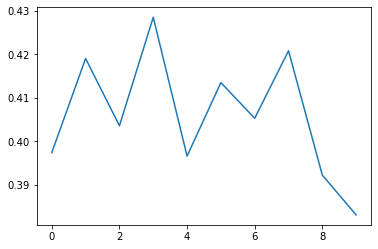

In [52]:
plt.plot(training_loss)

evaluation

In [56]:
count = 0


model.eval()
with torch.no_grad():
    for query_set, support_set, label in tqdm(train_loader):
        query_set = query_set.to(device)
        support_set = [supports.to(device) for supports in support_set]
        label = label.view(-1).long()

        proto = torch.cat(
            [model(supports).detach().cpu() for supports in support_set],
            dim=1,
        )
        res = model(query_set).detach().cpu()
        res = torch.cdist(res, proto).mean(dim=1).argmin(dim=1)
        count += torch.sum(res == label).item()

    print("acc", ":", count / len(train_dataset))

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:43<00:00,  1.35s/it]

acc= 0.248


In [ ]:
model_path = artifact_path / 'prototypical.pth'

In [57]:
torch.save(model.state_dict(), model_path)

In [36]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>